### Simon's Exploratory Data Analysis

#### Import Packages

In [153]:
import pandas as pd
from influxdb import DataFrameClient, InfluxDBClient
import pytz
import config
import seaborn as sns
import datetime
import matplotlib.pyplot as plt

#### Define DataFrameClient from Pandas

In [154]:
client = DataFrameClient(host = config.DB_HOST, port = config.DB_PORT, database = config.DB_DBNAME)

#### Query Data from InfluxDB

In [155]:
#Set time relative to now for Query (today: 00:00:00)
now = datetime.datetime.today()
past = now - datetime.timedelta(days = config.days_delta)

#Set start and end time
end_time = now.strftime("%Y-%m-%d %H:%M:%S")
start_time = past.strftime("%Y-%m-%d %H:%M:%S")

# NoSQL Query  (to be added: timezone adjusting)
query = "SELECT * FROM \"{}\",\"{}\" WHERE time >= '{}' AND time <= '{}' "\
                        .format(config.stations[0], config.stations[1], start_time, end_time)

df_temp = client.query(query)

# to create pandas df, use only one dicitonary part (mythenquai, tiefenbrunnen)
mythenquai_1y = pd.DataFrame(df_temp['mythenquai'])
mythenquai_1y.head()
tiefenbrunnen_1y = pd.DataFrame(df_temp['tiefenbrunnen'])
tiefenbrunnen_1y.head()

,air_temperature,barometric_pressure_qfe,dew_point,humidity,water_temperature,wind_direction,wind_force_avg_10min,wind_gust_max_10min,wind_speed_avg_10min,windchill
2018-11-29 19:10:00+00:00,5.0,969.3,3.8,92,9.5,45,0.0,0.1,0.0,5.0
2018-11-29 19:20:00+00:00,4.9,969.3,3.8,92,9.5,66,0.2,0.9,0.2,4.9
2018-11-29 19:30:00+00:00,4.8,969.3,3.7,93,9.5,53,0.1,0.7,0.1,4.8
2018-11-29 19:40:00+00:00,4.7,969.3,3.6,93,9.5,45,0.0,0.0,0.0,4.7
2018-11-29 19:50:00+00:00,4.5,969.4,3.5,93,9.5,0,0.0,0.0,0.0,4.5


### Exploratory Data Analysis

Aesthetische Mappings:

In [156]:
sns.set_style("darkgrid")
sns.set_palette("BrBG")

Formeln:

In [163]:
def rowindex_as_col(df):
    """add row index(time) to new column. df = dataframe, name_col = new column name"""
    df.index.name = "Time"
    df = df.reset_index(inplace=False)
    df = pd.DataFrame(df)
    return df

In [158]:
round(tiefenbrunnen_1y.describe(),1)

,air_temperature,barometric_pressure_qfe,dew_point,humidity,water_temperature,wind_direction,wind_force_avg_10min,wind_gust_max_10min,wind_speed_avg_10min,windchill
count,52515.0,52515.0,52515.0,52515.0,52515.0,52515.0,52515.0,52515.0,52515.0,52515.0
mean,11.9,969.0,7.1,74.8,13.4,133.2,1.0,2.6,1.2,11.2
std,7.7,8.1,6.2,15.4,6.8,112.6,1.2,2.9,1.6,8.0
min,-3.9,940.0,-7.4,19.0,4.7,0.0,0.0,0.0,0.0,-7.2
25%,5.7,964.7,2.0,65.0,6.7,32.0,0.0,0.6,0.0,4.7
50%,11.4,969.1,6.8,77.0,12.1,120.0,1.0,1.8,0.5,10.5
75%,17.4,973.5,12.3,87.0,19.6,210.0,2.0,3.6,1.6,17.2
max,35.8,988.4,23.4,100.0,27.9,360.0,12.4,29.5,12.6,35.9


In [159]:
round(mythenquai_1y.describe(),1)

,air_temperature,barometric_pressure_qfe,dew_point,global_radiation,humidity,precipitation,water_level,water_temperature,wind_direction,wind_force_avg_10min,wind_gust_max_10min,wind_speed_avg_10min,windchill
count,52477.0,52477.0,52477.0,52477.0,52477.0,52477.0,4632.0,52477.0,52477.0,52477.0,52477.0,52477.0,52477.0
mean,11.8,969.0,7.2,137.2,75.6,0.0,405.9,13.5,162.4,1.7,3.8,2.0,10.6
std,7.9,8.0,6.3,227.1,15.9,0.1,0.1,6.9,114.6,1.0,2.9,1.5,8.4
min,-3.9,940.3,-7.9,0.0,19.0,0.0,405.7,4.5,0.0,0.0,0.0,0.0,-7.7
25%,5.5,964.8,2.0,0.0,65.0,0.0,405.9,6.7,52.0,1.0,1.9,1.0,3.7
50%,11.2,969.2,6.9,3.0,78.0,0.0,405.9,12.3,157.0,2.0,3.2,1.8,9.8
75%,17.4,973.5,12.4,179.0,89.0,0.0,405.9,20.0,282.0,2.0,5.1,2.8,16.8
max,37.4,988.4,24.6,1000.0,100.0,9.0,406.1,27.7,360.0,9.0,23.5,17.1,37.6


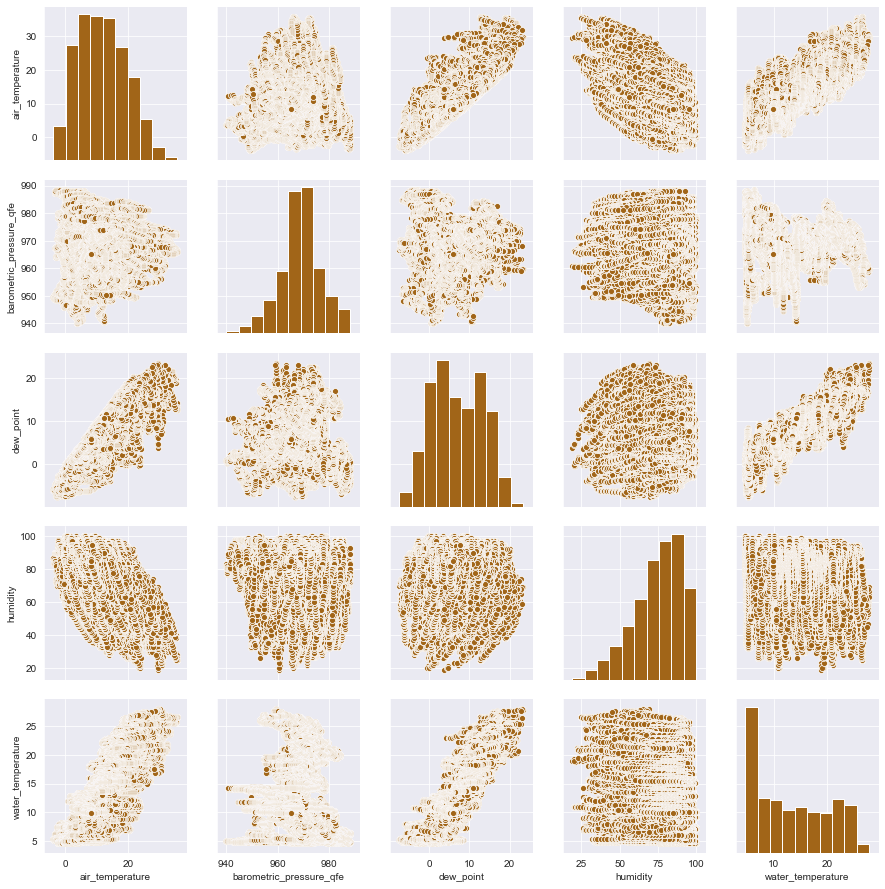

In [164]:
#sns.distplot(tiefenbrunnen_1y["air_temperature"], bins = 100, axlabel = "Lufttemperatur")
#plt.title("Distribution of temperature")
tiefenbrunnen_adapt = tiefenbrunnen_1y.drop( columns = ["wind_direction","wind_force_avg_10min","wind_gust_max_10min",
                                                       "wind_speed_avg_10min", "windchill"])


tiefenbrunnen_adapt = rowindex_as_col(tiefenbrunnen_adapt)
tiefenbrunnen_adapt.head()

#sns.pairplot(tiefenbrunnen_adapt)

In [118]:
tiefenbrunnen_1y.index.name = 'Time'
tiefenbrunnen_1y.reset_index(inplace=True)

tiefenbrunnen_1y.head()

,new,air_temperature,barometric_pressure_qfe,dew_point,humidity,water_temperature,wind_direction,wind_force_avg_10min,wind_gust_max_10min,wind_speed_avg_10min,windchill
new,,,,,,,,,,,
0,Time,5.9,969.3,4.4,90,9.5,295,1.0,1.5,1.0,5.9
1,Time,5.8,969.3,4.3,90,9.5,299,0.9,1.7,0.9,5.8
2,Time,5.8,969.3,4.3,90,9.5,297,0.7,1.3,0.7,5.8
3,Time,5.8,969.4,4.4,91,9.5,296,0.6,1.2,0.6,5.8
4,Time,5.7,969.4,4.3,91,9.5,305,0.7,1.2,0.7,5.7
